# Deep Learning | Laboratorio 1 | Clasificación de Aviones

## Notebook 2: Comparativa de 7 Modelos

Grupo 3:\
Dante Baldeón \| Roberto Hurtado \| Javier Linares


Este notebook entrena y compara 7 arquitecturas diferentes de redes neuronales convolucionales:

- **ResNet**: 18, 34, 50
- **EfficientNet**: B0, B1, B2
- **DenseNet**: 121

## Estructura del Notebook 2:

1.  **Configuración**: Librerias y dispositivos\
2.  **Dataset y transformaciones**: Carga y preparación de datos con división 80/10/10
3.  **Entrenamiento Inicial (15 épocas)**: Comparación de 7 modelos
    preentrenados.\
4.  **Entrenamiento Ampliado (50 épocas)**: EfficientNet-B1,
    EfficientNet-B2 y DenseNet-121.\
5.  **Resultados Finales y Conclusiones**: Precisión comparativa y
    análisis crítico.

## 1. Configuración


In [1]:
# Importaciones principales
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

# Librerías de análisis y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib en español
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("📦 Librerías importadas correctamente")
print(f"🐍 Python: {torch.__version__}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🤖 TIMM: {timm.__version__}")

/Users/javier/Documents/202508_DeepL_lab1_B/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 Librerías importadas correctamente
🐍 Python: 2.8.0
🔥 PyTorch: 2.8.0
🤖 TIMM: 1.0.19


In [2]:
# Configuración y detección automática de dispositivo
def detectar_dispositivo():
    """
    Detecta automáticamente el mejor dispositivo disponible:
    Prioridad: MPS (Mac M4) > CUDA (A100) > CPU
    """
    if torch.backends.mps.is_available():
        dispositivo = torch.device("mps")
        tipo_gpu = "Apple Silicon (MPS)"
        print("🍎 Dispositivo detectado: Apple Silicon con aceleración MPS")
    elif torch.cuda.is_available():
        dispositivo = torch.device("cuda")
        tipo_gpu = f"NVIDIA {torch.cuda.get_device_name(0)}"
        print(f"🚀 Dispositivo detectado: {tipo_gpu}")
        print(f"   - Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        dispositivo = torch.device("cpu")
        tipo_gpu = "CPU"
        print("💻 Usando CPU (sin aceleración GPU)")
    
    return dispositivo, tipo_gpu

# Detectar dispositivo
dispositivo, info_gpu = detectar_dispositivo()

# Configuración de semillas para reproducibilidad
semilla = 42
torch.manual_seed(semilla)
np.random.seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)

print(f"\n🎲 Semilla configurada: {semilla}")
print(f"📱 Dispositivo seleccionado: {dispositivo}")

🍎 Dispositivo detectado: Apple Silicon con aceleración MPS

🎲 Semilla configurada: 42
📱 Dispositivo seleccionado: mps


## 2. Preparación del Dataset con División 80/10/10

In [3]:
# Configuración del dataset
ruta_dataset_base = './data'
train_dir = os.path.join(ruta_dataset_base, 'train')
val_dir = os.path.join(ruta_dataset_base, 'val')
test_dir = os.path.join(ruta_dataset_base, 'test')

tamaño_lote_base = 32  # Batch size base, se ajustará por modelo
num_workers = 4

# Verificar que existe el dataset y sus splits
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"❌ No se encontró el directorio de entrenamiento: {train_dir}")
print(f"📁 Dataset base: {os.path.abspath(ruta_dataset_base)}")
print(f"   - train: {'✅' if os.path.exists(train_dir) else '❌'}")
print(f"   - val:   {'✅' if os.path.exists(val_dir) else '❌'}")
print(f"   - test:  {'✅' if os.path.exists(test_dir) else '❌'}")

# Transformación temporal para obtener info del dataset
transformacion_temp = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

# Cargar datasets por split (para info y como base)
dataset_train_base = datasets.ImageFolder(root=train_dir, transform=transformacion_temp)
dataset_val_base = datasets.ImageFolder(root=val_dir, transform=transformacion_temp) if os.path.exists(val_dir) else None
dataset_test_base = datasets.ImageFolder(root=test_dir, transform=transformacion_temp) if os.path.exists(test_dir) else None

num_clases = len(dataset_train_base.classes)
nombres_clases = dataset_train_base.classes

total_imagenes = len(dataset_train_base)
if dataset_val_base is not None:
    total_imagenes += len(dataset_val_base)
if dataset_test_base is not None:
    total_imagenes += len(dataset_test_base)

print(f"\n📊 Información del Dataset:")
print(f"   - Total de imágenes (train+val+test): {total_imagenes:,}")
print(f"   - Entrenamiento: {len(dataset_train_base):,}")
print(f"   - Validación:   {len(dataset_val_base) if dataset_val_base is not None else 0:,}")
print(f"   - Prueba:       {len(dataset_test_base) if dataset_test_base is not None else 0:,}")
print(f"   - Número de clases: {num_clases}")
print(f"   - Primeras 5 clases: {nombres_clases[:5]}")

📁 Dataset base: /Users/javier/Documents/202508_DeepL_lab1_B/data
   - train: ✅
   - val:   ✅
   - test:  ✅

📊 Información del Dataset:
   - Total de imágenes (train+val+test): 10,000
   - Entrenamiento: 8,000
   - Validación:   1,000
   - Prueba:       1,000
   - Número de clases: 100
   - Primeras 5 clases: ['707-320', '727-200', '737-200', '737-300', '737-400']


In [4]:
# Usar los splits ya preparados en ./data/train, ./data/val, ./data/test
print(f"📋 Usando splits predefinidos:")
print(f"   - Entrenamiento: {len(dataset_train_base):,}")
print(f"   - Validación:   {len(dataset_val_base) if dataset_val_base is not None else 0:,}")
print(f"   - Prueba:       {len(dataset_test_base) if dataset_test_base is not None else 0:,}")

datos_entrenamiento = dataset_train_base
datos_validacion = dataset_val_base if dataset_val_base is not None else dataset_train_base
print("\n✅ Splits configurados")

📋 Usando splits predefinidos:
   - Entrenamiento: 8,000
   - Validación:   1,000
   - Prueba:       1,000

✅ Splits configurados


In [5]:
# Configuraciones específicas por modelo
configuraciones_modelos = {
    'resnet18': {
        'nombre_timm': 'resnet18',
        'nombre_mostrar': 'ResNet-18',
        'tamaño_entrada': 224,
        'batch_size': 32,
        'familia': 'ResNet'
    },
    'resnet34': {
        'nombre_timm': 'resnet34',
        'nombre_mostrar': 'ResNet-34',
        'tamaño_entrada': 224,
        'batch_size': 32,
        'familia': 'ResNet'
    },
    'resnet50': {
        'nombre_timm': 'resnet50',
        'nombre_mostrar': 'ResNet-50',
        'tamaño_entrada': 224,
        'batch_size': 24,
        'familia': 'ResNet'
    },
    'efficientnet_b0': {
        'nombre_timm': 'efficientnet_b0',
        'nombre_mostrar': 'EfficientNet-B0',
        'tamaño_entrada': 224,
        'batch_size': 32,
        'familia': 'EfficientNet'
    },
    'efficientnet_b1': {
        'nombre_timm': 'efficientnet_b1',
        'nombre_mostrar': 'EfficientNet-B1',
        'tamaño_entrada': 240,
        'batch_size': 28,
        'familia': 'EfficientNet'
    },
    'efficientnet_b2': {
        'nombre_timm': 'efficientnet_b2',
        'nombre_mostrar': 'EfficientNet-B2',
        'tamaño_entrada': 260,
        'batch_size': 20,
        'familia': 'EfficientNet'
    },
    'densenet121': {
        'nombre_timm': 'densenet121',
        'nombre_mostrar': 'DenseNet-121',
        'tamaño_entrada': 224,
        'batch_size': 32,
        'familia': 'DenseNet'
    },
    'densenet169': {
        'nombre_timm': 'densenet169',
        'nombre_mostrar': 'DenseNet-169',
        'tamaño_entrada': 224,
        'batch_size': 24,
        'familia': 'DenseNet'
    }
}

# Mostrar tabla de configuraciones
print("⚙️ Configuraciones de los modelos:")
print("="*70)
print(f"{'Modelo':<20} {'Entrada':<10} {'Batch Size':<12} {'Familia':<15}")
print("="*70)
for modelo, config in configuraciones_modelos.items():
    print(f"{config['nombre_mostrar']:<20} {config['tamaño_entrada']}x{config['tamaño_entrada']:<5} {config['batch_size']:<12} {config['familia']:<15}")
print("="*70)

⚙️ Configuraciones de los modelos:
Modelo               Entrada    Batch Size   Familia        
ResNet-18            224x224   32           ResNet         
ResNet-34            224x224   32           ResNet         
ResNet-50            224x224   24           ResNet         
EfficientNet-B0      224x224   32           EfficientNet   
EfficientNet-B1      240x240   28           EfficientNet   
EfficientNet-B2      260x260   20           EfficientNet   
DenseNet-121         224x224   32           DenseNet       
DenseNet-169         224x224   24           DenseNet       


In [6]:
# Funciones auxiliares para el entrenamiento

def crear_transformaciones(tamaño_entrada, es_entrenamiento=True):
    """
    Crea transformaciones de datos optimizadas para cada fase.
    """
    if es_entrenamiento:
        return transforms.Compose([
            transforms.Resize(int(tamaño_entrada * 1.1)),
            transforms.RandomCrop(tamaño_entrada),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(int(tamaño_entrada * 1.14)),
            transforms.CenterCrop(tamaño_entrada),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def _set_transform(ds, transform):
    # Soporta ImageFolder o Subset(ImageFolder)
    if hasattr(ds, 'dataset') and ds.dataset is not None:
        ds.dataset.transform = transform
    else:
        ds.transform = transform

def crear_dataloaders(dataset_train, dataset_val, tamaño_lote, tamaño_entrada):
    """
    Crea dataloaders con las transformaciones apropiadas.
    Acepta ImageFolder o Subset.
    """
    # Aplicar transformaciones de forma segura
    _set_transform(dataset_train, crear_transformaciones(tamaño_entrada, es_entrenamiento=True))
    _set_transform(dataset_val, crear_transformaciones(tamaño_entrada, es_entrenamiento=False))
    
    # Crear dataloaders
    loader_entrenamiento = DataLoader(
        dataset_train,
        batch_size=tamaño_lote,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if dispositivo.type == 'cuda' else False
    )
    
    loader_validacion = DataLoader(
        dataset_val,
        batch_size=tamaño_lote * 2,  # Batch más grande para validación
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if dispositivo.type == 'cuda' else False
    )
    
    return loader_entrenamiento, loader_validacion

# Helper: crear ResNet con fine-tuning (descongelar layer4 + fc)

def crear_resnet_finetuning(nombre_timm: str, num_classes: int) -> nn.Module:
    """
    Crea una ResNet preentrenada con todas las capas congeladas excepto 'layer4' y 'fc'.
    Reemplaza el clasificador final con num_classes.
    """
    model = timm.create_model(nombre_timm, pretrained=True)
    # Congelar todas las capas
    for p in model.parameters():
        p.requires_grad = False
    # Descongelar layer4 si existe
    if hasattr(model, 'layer4'):
        for p in model.layer4.parameters():
            p.requires_grad = True
    # Reemplazar clasificador
    if hasattr(model, 'reset_classifier'):
        model.reset_classifier(num_classes=num_classes)
    else:
        if hasattr(model, 'fc') and isinstance(model.fc, nn.Linear):
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, num_classes)
        elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)
    # Asegurar que el clasificador esté entrenable
    if hasattr(model, 'fc') and hasattr(model.fc, 'parameters'):
        for p in model.fc.parameters():
            p.requires_grad = True
    if hasattr(model, 'classifier') and hasattr(model.classifier, 'parameters'):
        for p in model.classifier.parameters():
            p.requires_grad = True
    return model

# Nuevo: mover el modelo al dispositivo con registro de tiempo y opciones seguras

def mover_modelo_seguro(modelo: nn.Module, dispositivo: torch.device) -> nn.Module:
    """
    Mueve el modelo al dispositivo seleccionado con registro de tiempo.
    Usa non_blocking en CUDA cuando es posible. No cambia dtypes por defecto.
    """
    print(f"🔌 Moviendo modelo a {dispositivo}...")
    t0 = time.time()
    if dispositivo.type == 'cuda':
        modelo = modelo.to(dispositivo, non_blocking=True)
    else:
        modelo = modelo.to(dispositivo)
    dt = time.time() - t0
    print(f"✅ Modelo en {dispositivo} (t={dt:.1f}s)")
    return modelo

print("🔧 Funciones auxiliares definidas correctamente")

🔧 Funciones auxiliares definidas correctamente


In [7]:
# Función de entrenamiento optimizada

def entrenar_modelo(modelo, loader_train, loader_val, nombre_modelo, epocas=3):
    """
    Entrena un modelo por el número especificado de épocas.
    Retorna historial de métricas y modelo entrenado.
    """
    print(f"\n🚀 Iniciando entrenamiento de {nombre_modelo}")
    print(f"   - Épocas: {epocas}")
    print(f"   - Dispositivo: {dispositivo}")
    print(f"   - Lotes de entrenamiento: {len(loader_train)}")
    print(f"   - Lotes de validación: {len(loader_val)}")
    
    # Configuración del optimizador y criterio
    optimizador = optim.AdamW(modelo.parameters(), lr=1e-3, weight_decay=0.01)
    criterio = nn.CrossEntropyLoss()
    
    # Scheduler de learning rate
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizador,
        max_lr=1e-3,
        steps_per_epoch=len(loader_train),
        epochs=epocas
    )
    
    # Historial de métricas
    historial = {
        'loss_entrenamiento': [],
        'loss_validacion': [],
        'precision_entrenamiento': [],
        'precision_validacion': [],
        'precision_top5_validacion': [],
        'tiempos_epoca': []
    }
    
    mejor_precision = 0.0
    
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print(f"\nÉpoca {epoca + 1}/{epocas}")
        print("-" * 50)
        
        # === FASE DE ENTRENAMIENTO ===
        modelo.train()
        loss_epoch_train = 0.0
        correctos_train = 0
        total_train = 0
        
        pbar_train = tqdm(loader_train, desc=f"Entrenamiento", leave=False)
        for imagenes, etiquetas in pbar_train:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            
            # Forward pass
            optimizador.zero_grad()
            salidas = modelo(imagenes)
            loss = criterio(salidas, etiquetas)
            
            # Backward pass
            loss.backward()
            optimizador.step()
            scheduler.step()
            
            # Métricas
            loss_epoch_train += loss.item()
            _, predicciones = torch.max(salidas.data, 1)
            total_train += etiquetas.size(0)
            correctos_train += (predicciones == etiquetas).sum().item()
            
            # Actualizar barra de progreso
            precision_actual = 100.0 * correctos_train / total_train
            pbar_train.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{precision_actual:.2f}%'
            })
        
        # === FASE DE VALIDACIÓN ===
        modelo.eval()
        loss_epoch_val = 0.0
        correctos_val = 0
        correctos_top5 = 0
        total_val = 0
        
        with torch.no_grad():
            pbar_val = tqdm(loader_val, desc=f"Validación", leave=False)
            for imagenes, etiquetas in pbar_val:
                imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
                
                salidas = modelo(imagenes)
                loss = criterio(salidas, etiquetas)
                
                loss_epoch_val += loss.item()
                
                # Top-1 accuracy
                _, predicciones = torch.max(salidas, 1)
                total_val += etiquetas.size(0)
                correctos_val += (predicciones == etiquetas).sum().item()
                
                # Top-K accuracy (usar K = min(5, num_clases_modelo)) para evitar errores cuando hay <5 clases
                k = min(5, salidas.size(1))
                if k > 1:
                    _, topk_pred = salidas.topk(k, 1, True, True)
                    correctos_top5 += topk_pred.eq(etiquetas.view(-1, 1).expand_as(topk_pred)).sum().item()
                else:
                    # Si solo hay 1 clase, Top-5 equivale a Top-1
                    correctos_top5 += (predicciones == etiquetas).sum().item()
        
        # Calcular métricas de la época
        loss_promedio_train = loss_epoch_train / len(loader_train)
        loss_promedio_val = loss_epoch_val / len(loader_val)
        precision_train = 100.0 * correctos_train / total_train
        precision_val = 100.0 * correctos_val / total_val
        precision_top5 = 100.0 * correctos_top5 / total_val
        
        tiempo_epoca = time.time() - inicio_epoca
        
        # Guardar métricas
        historial['loss_entrenamiento'].append(loss_promedio_train)
        historial['loss_validacion'].append(loss_promedio_val)
        historial['precision_entrenamiento'].append(precision_train)
        historial['precision_validacion'].append(precision_val)
        historial['precision_top5_validacion'].append(precision_top5)
        historial['tiempos_epoca'].append(tiempo_epoca)
        
        # Actualizar mejor modelo
        if precision_val > mejor_precision:
            mejor_precision = precision_val
        
        # Mostrar resultados de la época
        print(f"Entrenamiento - Loss: {loss_promedio_train:.4f}, Precisión: {precision_train:.2f}%")
        print(f"Validación   - Loss: {loss_promedio_val:.4f}, Precisión: {precision_val:.2f}%, Top-5: {precision_top5:.2f}%")
        print(f"Tiempo: {tiempo_epoca:.1f}s, LR: {scheduler.get_last_lr()[0]:.2e}")
        
        # Limpiar caché de GPU
        if dispositivo.type == 'cuda':
            torch.cuda.empty_cache()
        elif dispositivo.type == 'mps':
            torch.mps.empty_cache()
    
    print(f"\n✅ Entrenamiento completado para {nombre_modelo}")
    print(f"   Mejor precisión: {mejor_precision:.2f}%")
    
    return historial, mejor_precision

print("📈 Función de entrenamiento definida")

📈 Función de entrenamiento definida


In [8]:
# Crear directorio para guardar checkpoints
directorio_checkpoints = Path('./checkpoints_modelos')
directorio_checkpoints.mkdir(exist_ok=True)

# Inicializar almacenamiento de resultados
resultados_modelos = {}
historiales_entrenamiento = {}
checkpoints_guardados = {}

print(f"📁 Directorio de checkpoints: {directorio_checkpoints}")
print("💾 Sistema de almacenamiento inicializado")

📁 Directorio de checkpoints: checkpoints_modelos
💾 Sistema de almacenamiento inicializado


## 3. Entrenamiento ResNet-18

In [9]:
# Configuración ResNet-18
nombre_modelo = 'resnet18'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']} (fine-tuning layer4 + fc)")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo con fine-tuning (descongelar layer4 + fc)
modelo_resnet18 = crear_resnet_finetuning(
    config['nombre_timm'],
    num_classes=num_clases
)
modelo_resnet18 = mover_modelo_seguro(modelo_resnet18, dispositivo)

# Crear dataloaders específicos
loader_train_resnet18, loader_val_resnet18 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

# Contar parámetros entrenables
entrenables = sum(p.numel() for p in modelo_resnet18.parameters() if p.requires_grad)
print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_resnet18.parameters()):,} parámetros (entrenables: {entrenables:,})")

🏗️ Preparando ResNet-18 (fine-tuning layer4 + fc)
   - Tamaño de entrada: 224x224
   - Batch size: 32
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.0s)
✅ ResNet-18 preparado con 11,227,812 parámetros (entrenables: 8,445,028)
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.0s)
✅ ResNet-18 preparado con 11,227,812 parámetros (entrenables: 8,445,028)


In [10]:
# Entrenar ResNet-18
inicio_total = time.time()

historial_resnet18, mejor_precision_resnet18 = entrenar_modelo(
    modelo_resnet18,
    loader_train_resnet18,
    loader_val_resnet18,
    config['nombre_mostrar'],
    epocas=10
)

tiempo_total_resnet18 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_resnet18.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_resnet18,
    'historial': historial_resnet18,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_resnet18['precision_validacion'][-1],
    'precision_top5_final': historial_resnet18['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_resnet18,
    'tiempo_total': tiempo_total_resnet18,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_resnet18
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_resnet18:.1f}s")


🚀 Iniciando entrenamiento de ResNet-18
   - Épocas: 10
   - Dispositivo: mps
   - Lotes de entrenamiento: 250
   - Lotes de validación: 16

Época 1/10
--------------------------------------------------


Entrenamiento - Loss: 4.5987, Precisión: 1.61%
Validación   - Loss: 4.5312, Precisión: 3.50%, Top-5: 13.10%
Tiempo: 71.4s, LR: 2.81e-04

Época 2/10
--------------------------------------------------


Entrenamiento - Loss: 4.1195, Precisión: 8.60%
Validación   - Loss: 3.3224, Precisión: 18.40%, Top-5: 47.10%
Tiempo: 71.6s, LR: 7.61e-04

Época 3/10
--------------------------------------------------


Entrenamiento - Loss: 2.9021, Precisión: 25.30%
Validación   - Loss: 2.3298, Precisión: 34.10%, Top-5: 69.80%
Tiempo: 71.2s, LR: 1.00e-03

Época 4/10
--------------------------------------------------


Entrenamiento - Loss: 2.1902, Precisión: 38.96%
Validación   - Loss: 1.8625, Precisión: 45.10%, Top-5: 79.80%
Tiempo: 71.9s, LR: 9.50e-04

Época 5/10
--------------------------------------------------


Entrenamiento - Loss: 1.7871, Precisión: 47.92%
Validación   - Loss: 1.6127, Precisión: 52.80%, Top-5: 82.80%
Tiempo: 71.9s, LR: 8.11e-04

Época 6/10
--------------------------------------------------


Entrenamiento - Loss: 1.5226, Precisión: 55.44%
Validación   - Loss: 1.4519, Precisión: 56.20%, Top-5: 86.90%
Tiempo: 71.2s, LR: 6.10e-04

Época 7/10
--------------------------------------------------


Entrenamiento - Loss: 1.3234, Precisión: 61.20%
Validación   - Loss: 1.3498, Precisión: 58.20%, Top-5: 87.50%
Tiempo: 71.2s, LR: 3.88e-04

Época 8/10
--------------------------------------------------


Entrenamiento - Loss: 1.1828, Precisión: 65.59%
Validación   - Loss: 1.3136, Precisión: 60.50%, Top-5: 87.50%
Tiempo: 71.2s, LR: 1.88e-04

Época 9/10
--------------------------------------------------


Entrenamiento - Loss: 1.1039, Precisión: 68.46%
Validación   - Loss: 1.2793, Precisión: 62.20%, Top-5: 88.60%
Tiempo: 71.4s, LR: 4.91e-05

Época 10/10
--------------------------------------------------


Entrenamiento - Loss: 1.0716, Precisión: 69.65%
Validación   - Loss: 1.2706, Precisión: 62.20%, Top-5: 88.30%
Tiempo: 71.2s, LR: 4.81e-09

✅ Entrenamiento completado para ResNet-18
   Mejor precisión: 62.20%

💾 Checkpoint guardado: checkpoints_modelos/resnet18_mejor.pth
⏱️ Tiempo total: 714.1s


## 4. Entrenamiento ResNet-34

In [18]:
# Configuración ResNet-34
nombre_modelo = 'resnet34'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']} (fine-tuning layer4 + fc)")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo con fine-tuning (descongelar layer4 + fc)
modelo_resnet34 = crear_resnet_finetuning(
    config['nombre_timm'],
    num_classes=num_clases
)
modelo_resnet34 = mover_modelo_seguro(modelo_resnet34, dispositivo)

# Crear dataloaders específicos
loader_train_resnet34, loader_val_resnet34 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

# Contar parámetros entrenables
entrenables = sum(p.numel() for p in modelo_resnet34.parameters() if p.requires_grad)
print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_resnet34.parameters()):,} parámetros (entrenables: {entrenables:,})")

🏗️ Preparando ResNet-34 (fine-tuning layer4 + fc)
   - Tamaño de entrada: 224x224
   - Batch size: 32
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ ResNet-34 preparado con 21,335,972 parámetros (entrenables: 13,165,668)
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ ResNet-34 preparado con 21,335,972 parámetros (entrenables: 13,165,668)


In [19]:
# Entrenar ResNet-34
inicio_total = time.time()

historial_resnet34, mejor_precision_resnet34 = entrenar_modelo(
    modelo_resnet34,
    loader_train_resnet34,
    loader_val_resnet34,
    config['nombre_mostrar'],
    epocas=10
)

tiempo_total_resnet34 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_resnet34.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_resnet34,
    'historial': historial_resnet34,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_resnet34['precision_validacion'][-1],
    'precision_top5_final': historial_resnet34['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_resnet34,
    'tiempo_total': tiempo_total_resnet34,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_resnet34
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_resnet34:.1f}s")


🚀 Iniciando entrenamiento de ResNet-34
   - Épocas: 10
   - Dispositivo: mps
   - Lotes de entrenamiento: 250
   - Lotes de validación: 16

Época 1/10
--------------------------------------------------


Entrenamiento - Loss: 4.6044, Precisión: 1.21%
Validación   - Loss: 4.5600, Precisión: 2.50%, Top-5: 10.30%
Tiempo: 87.1s, LR: 2.81e-04

Época 2/10
--------------------------------------------------


Entrenamiento - Loss: 4.2364, Precisión: 6.35%
Validación   - Loss: 3.3903, Precisión: 15.00%, Top-5: 43.30%
Tiempo: 87.4s, LR: 7.61e-04

Época 3/10
--------------------------------------------------


Entrenamiento - Loss: 2.9434, Precisión: 22.43%
Validación   - Loss: 2.3258, Precisión: 31.30%, Top-5: 70.70%
Tiempo: 86.5s, LR: 1.00e-03

Época 4/10
--------------------------------------------------


Entrenamiento - Loss: 2.2586, Precisión: 35.74%
Validación   - Loss: 1.8677, Precisión: 44.60%, Top-5: 80.20%
Tiempo: 86.7s, LR: 9.50e-04

Época 5/10
--------------------------------------------------


Entrenamiento - Loss: 1.8867, Precisión: 44.24%
Validación   - Loss: 1.6348, Precisión: 49.60%, Top-5: 83.60%
Tiempo: 86.2s, LR: 8.11e-04

Época 6/10
--------------------------------------------------


Entrenamiento - Loss: 1.6107, Precisión: 51.60%
Validación   - Loss: 1.4844, Precisión: 53.90%, Top-5: 86.70%
Tiempo: 86.1s, LR: 6.10e-04

Época 7/10
--------------------------------------------------


Entrenamiento - Loss: 1.4160, Precisión: 57.60%
Validación   - Loss: 1.3560, Precisión: 57.20%, Top-5: 87.40%
Tiempo: 86.4s, LR: 3.88e-04

Época 8/10
--------------------------------------------------


Entrenamiento - Loss: 1.2725, Precisión: 61.49%
Validación   - Loss: 1.3180, Precisión: 59.20%, Top-5: 88.20%
Tiempo: 86.1s, LR: 1.88e-04

Época 9/10
--------------------------------------------------


Entrenamiento - Loss: 1.1828, Precisión: 64.00%
Validación   - Loss: 1.2861, Precisión: 59.30%, Top-5: 89.30%
Tiempo: 90.2s, LR: 4.91e-05

Época 10/10
--------------------------------------------------


Entrenamiento - Loss: 1.1417, Precisión: 65.94%
Validación   - Loss: 1.2689, Precisión: 60.60%, Top-5: 89.50%
Tiempo: 87.2s, LR: 4.81e-09

✅ Entrenamiento completado para ResNet-34
   Mejor precisión: 60.60%

💾 Checkpoint guardado: checkpoints_modelos/resnet34_mejor.pth
⏱️ Tiempo total: 870.3s

💾 Checkpoint guardado: checkpoints_modelos/resnet34_mejor.pth
⏱️ Tiempo total: 870.3s


## 5. Entrenamiento ResNet-50

In [20]:
# Configuración ResNet-50
nombre_modelo = 'resnet50'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']} (fine-tuning layer4 + fc)")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo con fine-tuning (descongelar layer4 + fc)
modelo_resnet50 = crear_resnet_finetuning(
    config['nombre_timm'],
    num_classes=num_clases
)
modelo_resnet50 = mover_modelo_seguro(modelo_resnet50, dispositivo)

# Crear dataloaders específicos
loader_train_resnet50, loader_val_resnet50 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

# Contar parámetros entrenables
entrenables = sum(p.numel() for p in modelo_resnet50.parameters() if p.requires_grad)
print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_resnet50.parameters()):,} parámetros (entrenables: {entrenables:,})")

🏗️ Preparando ResNet-50 (fine-tuning layer4 + fc)
   - Tamaño de entrada: 224x224
   - Batch size: 24
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ ResNet-50 preparado con 23,712,932 parámetros (entrenables: 15,169,636)
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ ResNet-50 preparado con 23,712,932 parámetros (entrenables: 15,169,636)


In [21]:
# Entrenar ResNet-50
inicio_total = time.time()

historial_resnet50, mejor_precision_resnet50 = entrenar_modelo(
    modelo_resnet50,
    loader_train_resnet50,
    loader_val_resnet50,
    config['nombre_mostrar'],
    epocas=10
)

tiempo_total_resnet50 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_resnet50.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_resnet50,
    'historial': historial_resnet50,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_resnet50['precision_validacion'][-1],
    'precision_top5_final': historial_resnet50['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_resnet50,
    'tiempo_total': tiempo_total_resnet50,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_resnet50
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_resnet50:.1f}s")


🚀 Iniciando entrenamiento de ResNet-50
   - Épocas: 10
   - Dispositivo: mps
   - Lotes de entrenamiento: 334
   - Lotes de validación: 21

Época 1/10
--------------------------------------------------


Entrenamiento - Loss: 4.5888, Precisión: 1.75%
Validación   - Loss: 4.4735, Precisión: 5.00%, Top-5: 17.40%
Tiempo: 128.9s, LR: 2.80e-04

Época 2/10
--------------------------------------------------


Entrenamiento - Loss: 3.5995, Precisión: 13.41%
Validación   - Loss: 2.7023, Precisión: 23.90%, Top-5: 58.30%
Tiempo: 126.8s, LR: 7.61e-04

Época 3/10
--------------------------------------------------


Entrenamiento - Loss: 2.3653, Precisión: 33.84%
Validación   - Loss: 1.8861, Precisión: 42.90%, Top-5: 79.00%
Tiempo: 126.8s, LR: 1.00e-03

Época 4/10
--------------------------------------------------


Entrenamiento - Loss: 1.7622, Precisión: 47.19%
Validación   - Loss: 1.4900, Precisión: 54.30%, Top-5: 87.30%
Tiempo: 126.9s, LR: 9.50e-04

Época 5/10
--------------------------------------------------


Entrenamiento - Loss: 1.4089, Precisión: 56.26%
Validación   - Loss: 1.2894, Precisión: 59.60%, Top-5: 89.50%
Tiempo: 127.9s, LR: 8.11e-04

Época 6/10
--------------------------------------------------


Entrenamiento - Loss: 1.1465, Precisión: 64.06%
Validación   - Loss: 1.2172, Precisión: 63.10%, Top-5: 91.90%
Tiempo: 127.2s, LR: 6.11e-04

Época 7/10
--------------------------------------------------


Entrenamiento - Loss: 0.9510, Precisión: 70.12%
Validación   - Loss: 1.0346, Precisión: 69.00%, Top-5: 92.60%
Tiempo: 127.4s, LR: 3.88e-04

Época 8/10
--------------------------------------------------


Entrenamiento - Loss: 0.8015, Precisión: 75.03%
Validación   - Loss: 0.9955, Precisión: 69.80%, Top-5: 92.90%
Tiempo: 126.9s, LR: 1.88e-04

Época 9/10
--------------------------------------------------


Entrenamiento - Loss: 0.7005, Precisión: 77.97%
Validación   - Loss: 1.0700, Precisión: 70.00%, Top-5: 93.20%
Tiempo: 127.1s, LR: 4.92e-05

Época 10/10
--------------------------------------------------


Entrenamiento - Loss: 0.6626, Precisión: 79.55%
Validación   - Loss: 0.9906, Precisión: 70.40%, Top-5: 93.10%
Tiempo: 127.2s, LR: 4.45e-09

✅ Entrenamiento completado para ResNet-50
   Mejor precisión: 70.40%

💾 Checkpoint guardado: checkpoints_modelos/resnet50_mejor.pth
⏱️ Tiempo total: 1273.1s

💾 Checkpoint guardado: checkpoints_modelos/resnet50_mejor.pth
⏱️ Tiempo total: 1273.1s


## 6. Entrenamiento EfficientNet-B0

In [22]:
# Configuración EfficientNet-B0
nombre_modelo = 'efficientnet_b0'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']}")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo
modelo_efficientnet_b0 = timm.create_model(
    config['nombre_timm'], 
    pretrained=True, 
    num_classes=num_clases
)
# Mover modelo al dispositivo con helper
modelo_efficientnet_b0 = mover_modelo_seguro(modelo_efficientnet_b0, dispositivo)

# Crear dataloaders específicos
loader_train_effb0, loader_val_effb0 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_efficientnet_b0.parameters()):,} parámetros")

🏗️ Preparando EfficientNet-B0
   - Tamaño de entrada: 224x224
   - Batch size: 32
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ EfficientNet-B0 preparado con 4,135,648 parámetros
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ EfficientNet-B0 preparado con 4,135,648 parámetros


In [23]:
# Entrenar EfficientNet-B0
inicio_total = time.time()

historial_efficientnet_b0, mejor_precision_efficientnet_b0 = entrenar_modelo(
    modelo_efficientnet_b0,
    loader_train_effb0,
    loader_val_effb0,
    config['nombre_mostrar'],
    epocas=15
)

tiempo_total_efficientnet_b0 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_efficientnet_b0.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_efficientnet_b0,
    'historial': historial_efficientnet_b0,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_efficientnet_b0['precision_validacion'][-1],
    'precision_top5_final': historial_efficientnet_b0['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_efficientnet_b0,
    'tiempo_total': tiempo_total_efficientnet_b0,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_efficientnet_b0
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_efficientnet_b0:.1f}s")


🚀 Iniciando entrenamiento de EfficientNet-B0
   - Épocas: 15
   - Dispositivo: mps
   - Lotes de entrenamiento: 250
   - Lotes de validación: 16

Época 1/15
--------------------------------------------------


Entrenamiento - Loss: 4.5266, Precisión: 3.95%
Validación   - Loss: 3.8177, Precisión: 14.40%, Top-5: 34.30%
Tiempo: 149.5s, LR: 1.52e-04

Época 2/15
--------------------------------------------------


Entrenamiento - Loss: 2.6940, Precisión: 32.29%
Validación   - Loss: 1.6980, Precisión: 51.20%, Top-5: 84.40%
Tiempo: 148.9s, LR: 4.37e-04

Época 3/15
--------------------------------------------------


Entrenamiento - Loss: 1.5039, Precisión: 55.09%
Validación   - Loss: 1.4054, Precisión: 57.60%, Top-5: 89.60%
Tiempo: 148.5s, LR: 7.61e-04

Época 4/15
--------------------------------------------------


Entrenamiento - Loss: 1.2131, Precisión: 62.58%
Validación   - Loss: 1.2380, Precisión: 62.70%, Top-5: 91.10%
Tiempo: 148.2s, LR: 9.71e-04

Época 5/15
--------------------------------------------------


Entrenamiento - Loss: 0.9656, Precisión: 69.66%
Validación   - Loss: 0.9830, Precisión: 70.10%, Top-5: 93.20%
Tiempo: 148.0s, LR: 9.94e-04

Época 6/15
--------------------------------------------------


Entrenamiento - Loss: 0.7398, Precisión: 76.28%
Validación   - Loss: 0.9308, Precisión: 71.20%, Top-5: 93.90%
Tiempo: 148.0s, LR: 9.50e-04

Época 7/15
--------------------------------------------------


Entrenamiento - Loss: 0.5597, Precisión: 81.45%
Validación   - Loss: 0.9066, Precisión: 73.00%, Top-5: 94.60%
Tiempo: 148.4s, LR: 8.66e-04

Época 8/15
--------------------------------------------------


Entrenamiento - Loss: 0.4289, Precisión: 85.61%
Validación   - Loss: 0.9219, Precisión: 74.90%, Top-5: 94.30%
Tiempo: 147.9s, LR: 7.49e-04

Época 9/15
--------------------------------------------------


Entrenamiento - Loss: 0.3061, Precisión: 89.56%
Validación   - Loss: 0.9206, Precisión: 75.80%, Top-5: 94.20%
Tiempo: 147.9s, LR: 6.11e-04

Época 10/15
--------------------------------------------------


Entrenamiento - Loss: 0.2067, Precisión: 93.14%
Validación   - Loss: 0.8284, Precisión: 79.60%, Top-5: 94.80%
Tiempo: 147.9s, LR: 4.62e-04

Época 11/15
--------------------------------------------------


Entrenamiento - Loss: 0.1345, Precisión: 95.88%
Validación   - Loss: 0.7851, Precisión: 81.60%, Top-5: 95.00%
Tiempo: 148.3s, LR: 3.17e-04

Época 12/15
--------------------------------------------------


Entrenamiento - Loss: 0.0838, Precisión: 97.51%
Validación   - Loss: 0.7459, Precisión: 82.90%, Top-5: 95.70%
Tiempo: 148.1s, LR: 1.88e-04

Época 13/15
--------------------------------------------------


Entrenamiento - Loss: 0.0625, Precisión: 98.14%
Validación   - Loss: 0.7551, Precisión: 82.50%, Top-5: 95.30%
Tiempo: 148.0s, LR: 8.65e-05

Época 14/15
--------------------------------------------------


Entrenamiento - Loss: 0.0465, Precisión: 98.85%
Validación   - Loss: 0.7530, Precisión: 81.90%, Top-5: 95.60%
Tiempo: 147.8s, LR: 2.20e-05

Época 15/15
--------------------------------------------------


Entrenamiento - Loss: 0.0414, Precisión: 98.95%
Validación   - Loss: 0.7592, Precisión: 81.70%, Top-5: 95.40%
Tiempo: 148.4s, LR: 4.36e-09

✅ Entrenamiento completado para EfficientNet-B0
   Mejor precisión: 82.90%

💾 Checkpoint guardado: checkpoints_modelos/efficientnet_b0_mejor.pth
⏱️ Tiempo total: 2224.5s


## 7. Entrenamiento EfficientNet-B1

In [24]:
# Configuración EfficientNet-B1
nombre_modelo = 'efficientnet_b1'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']}")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo
modelo_efficientnet_b1 = timm.create_model(
    config['nombre_timm'], 
    pretrained=True, 
    num_classes=num_clases
)
modelo_efficientnet_b1 = mover_modelo_seguro(modelo_efficientnet_b1, dispositivo)

# Crear dataloaders específicos
loader_train_effb1, loader_val_effb1 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_efficientnet_b1.parameters()):,} parámetros")

🏗️ Preparando EfficientNet-B1
   - Tamaño de entrada: 240x240
   - Batch size: 28


🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.1s)
✅ EfficientNet-B1 preparado con 6,641,284 parámetros


In [25]:
# Entrenar EfficientNet-B1
inicio_total = time.time()

historial_efficientnet_b1, mejor_precision_efficientnet_b1 = entrenar_modelo(
    modelo_efficientnet_b1,
    loader_train_effb1,
    loader_val_effb1,
    config['nombre_mostrar'],
    epocas=15
)

tiempo_total_efficientnet_b1 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_efficientnet_b1.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_efficientnet_b1,
    'historial': historial_efficientnet_b1,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_efficientnet_b1['precision_validacion'][-1],
    'precision_top5_final': historial_efficientnet_b1['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_efficientnet_b1,
    'tiempo_total': tiempo_total_efficientnet_b1,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_efficientnet_b1
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_efficientnet_b1:.1f}s")


🚀 Iniciando entrenamiento de EfficientNet-B1
   - Épocas: 15
   - Dispositivo: mps
   - Lotes de entrenamiento: 286
   - Lotes de validación: 18

Época 1/15
--------------------------------------------------


Entrenamiento - Loss: 4.0250, Precisión: 11.53%
Validación   - Loss: 2.4502, Precisión: 36.60%, Top-5: 67.70%
Tiempo: 217.0s, LR: 1.52e-04

Época 2/15
--------------------------------------------------


Entrenamiento - Loss: 2.0718, Precisión: 41.90%
Validación   - Loss: 2654745850.9996, Precisión: 39.70%, Top-5: 75.60%
Tiempo: 212.1s, LR: 4.37e-04

Época 3/15
--------------------------------------------------


Entrenamiento - Loss: 1.9054, Precisión: 45.23%
Validación   - Loss: 2.0235, Precisión: 44.00%, Top-5: 81.00%
Tiempo: 212.5s, LR: 7.61e-04

Época 4/15
--------------------------------------------------


Entrenamiento - Loss: 1.6859, Precisión: 50.38%
Validación   - Loss: 1.7790, Precisión: 49.10%, Top-5: 84.10%
Tiempo: 212.4s, LR: 9.71e-04

Época 5/15
--------------------------------------------------


Entrenamiento - Loss: 1.4571, Precisión: 56.44%
Validación   - Loss: 1.3190, Precisión: 62.10%, Top-5: 88.40%
Tiempo: 212.8s, LR: 9.94e-04

Época 6/15
--------------------------------------------------


Entrenamiento - Loss: 1.2037, Precisión: 62.50%
Validación   - Loss: 1.2112, Precisión: 63.30%, Top-5: 90.70%
Tiempo: 213.0s, LR: 9.50e-04

Época 7/15
--------------------------------------------------


Entrenamiento - Loss: 0.9911, Precisión: 68.11%
Validación   - Loss: 1.0991, Precisión: 66.90%, Top-5: 91.70%
Tiempo: 213.6s, LR: 8.66e-04

Época 8/15
--------------------------------------------------


Entrenamiento - Loss: 0.8292, Precisión: 73.72%
Validación   - Loss: 1.0147, Precisión: 69.70%, Top-5: 92.10%
Tiempo: 213.3s, LR: 7.50e-04

Época 9/15
--------------------------------------------------


Entrenamiento - Loss: 0.6677, Precisión: 77.85%
Validación   - Loss: 0.8283, Precisión: 75.40%, Top-5: 94.20%
Tiempo: 214.6s, LR: 6.11e-04

Época 10/15
--------------------------------------------------


Entrenamiento - Loss: 0.5253, Precisión: 82.47%
Validación   - Loss: 0.7425, Precisión: 77.90%, Top-5: 94.90%
Tiempo: 214.0s, LR: 4.62e-04

Época 11/15
--------------------------------------------------


Entrenamiento - Loss: 0.3573, Precisión: 88.58%
Validación   - Loss: 0.7020, Precisión: 80.10%, Top-5: 95.10%
Tiempo: 212.7s, LR: 3.17e-04

Época 12/15
--------------------------------------------------


Entrenamiento - Loss: 0.2443, Precisión: 91.89%
Validación   - Loss: 0.6665, Precisión: 83.20%, Top-5: 95.00%
Tiempo: 213.0s, LR: 1.88e-04

Época 13/15
--------------------------------------------------


Entrenamiento - Loss: 0.1585, Precisión: 95.11%
Validación   - Loss: 0.6436, Precisión: 83.90%, Top-5: 95.70%
Tiempo: 213.0s, LR: 8.66e-05

Época 14/15
--------------------------------------------------


Entrenamiento - Loss: 0.1164, Precisión: 96.61%
Validación   - Loss: 0.6298, Precisión: 85.70%, Top-5: 95.70%
Tiempo: 214.0s, LR: 2.21e-05

Época 15/15
--------------------------------------------------


Entrenamiento - Loss: 0.0996, Precisión: 97.19%
Validación   - Loss: 0.6269, Precisión: 85.30%, Top-5: 95.50%
Tiempo: 214.5s, LR: 4.27e-09

✅ Entrenamiento completado para EfficientNet-B1
   Mejor precisión: 85.70%

💾 Checkpoint guardado: checkpoints_modelos/efficientnet_b1_mejor.pth
⏱️ Tiempo total: 3203.3s


## 8. Entrenamiento EfficientNet-B2

In [26]:
# Configuración EfficientNet-B2
nombre_modelo = 'efficientnet_b2'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']}")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo
modelo_efficientnet_b2 = timm.create_model(
    config['nombre_timm'], 
    pretrained=True, 
    num_classes=num_clases
)
modelo_efficientnet_b2 = mover_modelo_seguro(modelo_efficientnet_b2, dispositivo)

# Crear dataloaders específicos
loader_train_effb2, loader_val_effb2 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_efficientnet_b2.parameters()):,} parámetros")

🏗️ Preparando EfficientNet-B2
   - Tamaño de entrada: 260x260
   - Batch size: 20
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.2s)
✅ EfficientNet-B2 preparado con 7,841,894 parámetros
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.2s)
✅ EfficientNet-B2 preparado con 7,841,894 parámetros


In [27]:
# Entrenar EfficientNet-B2
inicio_total = time.time()

historial_efficientnet_b2, mejor_precision_efficientnet_b2 = entrenar_modelo(
    modelo_efficientnet_b2,
    loader_train_effb2,
    loader_val_effb2,
    config['nombre_mostrar'],
    epocas=15
)

tiempo_total_efficientnet_b2 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_efficientnet_b2.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_efficientnet_b2,
    'historial': historial_efficientnet_b2,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_efficientnet_b2['precision_validacion'][-1],
    'precision_top5_final': historial_efficientnet_b2['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_efficientnet_b2,
    'tiempo_total': tiempo_total_efficientnet_b2,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_efficientnet_b2
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_efficientnet_b2:.1f}s")


🚀 Iniciando entrenamiento de EfficientNet-B2
   - Épocas: 15
   - Dispositivo: mps
   - Lotes de entrenamiento: 400
   - Lotes de validación: 25

Época 1/15
--------------------------------------------------


Entrenamiento - Loss: 4.2046, Precisión: 8.71%
Validación   - Loss: 2.6608, Precisión: 30.80%, Top-5: 64.80%
Tiempo: 289.2s, LR: 1.52e-04

Época 2/15
--------------------------------------------------


Entrenamiento - Loss: 1.8823, Precisión: 47.56%
Validación   - Loss: 1.2567, Precisión: 63.00%, Top-5: 91.20%
Tiempo: 287.5s, LR: 4.37e-04

Época 3/15
--------------------------------------------------


Entrenamiento - Loss: 1.3074, Precisión: 60.50%
Validación   - Loss: 1.1492, Precisión: 64.10%, Top-5: 91.20%
Tiempo: 286.4s, LR: 7.60e-04

Época 4/15
--------------------------------------------------


Entrenamiento - Loss: 1.0824, Precisión: 66.71%
Validación   - Loss: 1.0825, Precisión: 69.70%, Top-5: 92.50%
Tiempo: 285.8s, LR: 9.71e-04

Época 5/15
--------------------------------------------------


Entrenamiento - Loss: 0.8717, Precisión: 71.94%
Validación   - Loss: 0.9755, Precisión: 70.90%, Top-5: 94.00%
Tiempo: 286.0s, LR: 9.94e-04

Época 6/15
--------------------------------------------------


Entrenamiento - Loss: 0.6801, Precisión: 77.61%
Validación   - Loss: 0.8194, Precisión: 76.30%, Top-5: 95.10%
Tiempo: 285.6s, LR: 9.50e-04

Época 7/15
--------------------------------------------------


Entrenamiento - Loss: 0.5529, Precisión: 81.46%
Validación   - Loss: 0.7880, Precisión: 77.00%, Top-5: 94.80%
Tiempo: 285.8s, LR: 8.66e-04

Época 8/15
--------------------------------------------------


Entrenamiento - Loss: 0.4205, Precisión: 85.84%
Validación   - Loss: 0.6819, Precisión: 80.90%, Top-5: 95.20%
Tiempo: 285.8s, LR: 7.50e-04

Época 9/15
--------------------------------------------------


Entrenamiento - Loss: 0.3078, Precisión: 89.19%
Validación   - Loss: 0.6793, Precisión: 83.30%, Top-5: 95.60%
Tiempo: 285.7s, LR: 6.11e-04

Época 10/15
--------------------------------------------------


Entrenamiento - Loss: 0.2009, Precisión: 92.85%
Validación   - Loss: 0.6497, Precisión: 83.80%, Top-5: 95.90%
Tiempo: 287.5s, LR: 4.62e-04

Época 11/15
--------------------------------------------------


Entrenamiento - Loss: 0.1170, Precisión: 95.70%
Validación   - Loss: 0.6277, Precisión: 84.90%, Top-5: 95.80%
Tiempo: 285.2s, LR: 3.17e-04

Época 12/15
--------------------------------------------------


Entrenamiento - Loss: 0.0873, Precisión: 96.97%
Validación   - Loss: 0.6408, Precisión: 86.40%, Top-5: 96.40%
Tiempo: 285.0s, LR: 1.88e-04

Época 13/15
--------------------------------------------------


Entrenamiento - Loss: 0.0476, Precisión: 98.76%
Validación   - Loss: 0.6129, Precisión: 86.50%, Top-5: 96.00%
Tiempo: 286.1s, LR: 8.67e-05

Época 14/15
--------------------------------------------------


Entrenamiento - Loss: 0.0337, Precisión: 99.11%
Validación   - Loss: 0.6161, Precisión: 87.50%, Top-5: 96.10%
Tiempo: 285.8s, LR: 2.21e-05

Época 15/15
--------------------------------------------------


Entrenamiento - Loss: 0.0293, Precisión: 99.28%
Validación   - Loss: 0.6057, Precisión: 87.10%, Top-5: 96.30%
Tiempo: 300.7s, LR: 4.14e-09

✅ Entrenamiento completado para EfficientNet-B2
   Mejor precisión: 87.50%

💾 Checkpoint guardado: checkpoints_modelos/efficientnet_b2_mejor.pth
⏱️ Tiempo total: 4308.9s


## 9. Entrenamiento DenseNet-121

In [39]:
# Configuración DenseNet-121
nombre_modelo = 'densenet121'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']}")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo
modelo_densenet121 = timm.create_model(
    config['nombre_timm'], 
    pretrained=True, 
    num_classes=num_clases
)
modelo_densenet121 = mover_modelo_seguro(modelo_densenet121, dispositivo)

# Crear dataloaders específicos
loader_train_dense121, loader_val_dense121 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_densenet121.parameters()):,} parámetros")

🏗️ Preparando DenseNet-121
   - Tamaño de entrada: 224x224
   - Batch size: 32
🔌 Moviendo modelo a mps...
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.4s)
✅ DenseNet-121 preparado con 7,056,356 parámetros
✅ Modelo en mps (t=0.4s)
✅ DenseNet-121 preparado con 7,056,356 parámetros


In [40]:
# Entrenar DenseNet-121
inicio_total = time.time()

historial_densenet121, mejor_precision_densenet121 = entrenar_modelo(
    modelo_densenet121,
    loader_train_dense121,
    loader_val_dense121,
    config['nombre_mostrar'],
    epocas=15
)

tiempo_total_densenet121 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_densenet121.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_densenet121,
    'historial': historial_densenet121,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_densenet121['precision_validacion'][-1],
    'precision_top5_final': historial_densenet121['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_densenet121,
    'tiempo_total': tiempo_total_densenet121,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_densenet121
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_densenet121:.1f}s")


🚀 Iniciando entrenamiento de DenseNet-121
   - Épocas: 15
   - Dispositivo: mps
   - Lotes de entrenamiento: 250
   - Lotes de validación: 16

Época 1/15
--------------------------------------------------


Entrenamiento - Loss: 4.4992, Precisión: 3.75%
Validación   - Loss: 3.8962, Precisión: 15.50%, Top-5: 39.30%
Tiempo: 232.3s, LR: 1.52e-04

Época 2/15
--------------------------------------------------


Entrenamiento - Loss: 2.8770, Precisión: 30.20%
Validación   - Loss: 2.0252, Precisión: 44.30%, Top-5: 77.00%
Tiempo: 228.1s, LR: 4.37e-04

Época 3/15
--------------------------------------------------


Entrenamiento - Loss: 1.7569, Precisión: 50.14%
Validación   - Loss: 1.5875, Precisión: 53.40%, Top-5: 84.50%
Tiempo: 228.3s, LR: 7.61e-04

Época 4/15
--------------------------------------------------


Entrenamiento - Loss: 1.4778, Precisión: 56.08%
Validación   - Loss: 1.7505, Precisión: 51.90%, Top-5: 83.30%
Tiempo: 227.1s, LR: 9.71e-04

Época 5/15
--------------------------------------------------


Entrenamiento - Loss: 1.2416, Precisión: 62.00%
Validación   - Loss: 1.4934, Precisión: 55.80%, Top-5: 88.10%
Tiempo: 227.1s, LR: 9.94e-04

Época 6/15
--------------------------------------------------


Entrenamiento - Loss: 0.9905, Precisión: 68.99%
Validación   - Loss: 1.0363, Precisión: 67.20%, Top-5: 92.10%
Tiempo: 223.5s, LR: 9.50e-04

Época 7/15
--------------------------------------------------


Entrenamiento - Loss: 0.8094, Precisión: 73.91%
Validación   - Loss: 1.0209, Precisión: 70.00%, Top-5: 91.60%
Tiempo: 224.5s, LR: 8.66e-04

Época 8/15
--------------------------------------------------


Entrenamiento - Loss: 0.6380, Precisión: 78.80%
Validación   - Loss: 0.9884, Precisión: 70.40%, Top-5: 93.30%
Tiempo: 221.2s, LR: 7.49e-04

Época 9/15
--------------------------------------------------


Entrenamiento - Loss: 0.4997, Precisión: 83.81%
Validación   - Loss: 0.7915, Precisión: 77.30%, Top-5: 94.90%
Tiempo: 225.3s, LR: 6.11e-04

Época 10/15
--------------------------------------------------


Entrenamiento - Loss: 0.3703, Precisión: 87.64%
Validación   - Loss: 0.7382, Precisión: 77.60%, Top-5: 94.80%
Tiempo: 233.2s, LR: 4.62e-04

Época 11/15
--------------------------------------------------


Entrenamiento - Loss: 0.2466, Precisión: 92.46%
Validación   - Loss: 0.6765, Precisión: 82.00%, Top-5: 95.40%
Tiempo: 232.0s, LR: 3.17e-04

Época 12/15
--------------------------------------------------


Entrenamiento - Loss: 0.1712, Precisión: 95.00%
Validación   - Loss: 0.6457, Precisión: 82.70%, Top-5: 95.40%
Tiempo: 234.3s, LR: 1.88e-04

Época 13/15
--------------------------------------------------


Entrenamiento - Loss: 0.1223, Precisión: 97.00%
Validación   - Loss: 0.6658, Precisión: 82.10%, Top-5: 95.70%
Tiempo: 232.2s, LR: 8.65e-05

Época 14/15
--------------------------------------------------


Entrenamiento - Loss: 0.0996, Precisión: 97.72%
Validación   - Loss: 0.6591, Precisión: 82.40%, Top-5: 95.90%
Tiempo: 232.1s, LR: 2.20e-05

Época 15/15
--------------------------------------------------


Entrenamiento - Loss: 0.0868, Precisión: 98.44%
Validación   - Loss: 0.6510, Precisión: 82.50%, Top-5: 95.60%
Tiempo: 230.2s, LR: 4.36e-09

✅ Entrenamiento completado para DenseNet-121
   Mejor precisión: 82.70%

💾 Checkpoint guardado: checkpoints_modelos/densenet121_mejor.pth
⏱️ Tiempo total: 3431.9s

💾 Checkpoint guardado: checkpoints_modelos/densenet121_mejor.pth
⏱️ Tiempo total: 3431.9s


In [37]:
# Configuración DenseNet-169
nombre_modelo = 'densenet169'
config = configuraciones_modelos[nombre_modelo]

print(f"🏗️ Preparando {config['nombre_mostrar']}")
print(f"   - Tamaño de entrada: {config['tamaño_entrada']}x{config['tamaño_entrada']}")
print(f"   - Batch size: {config['batch_size']}")

# Crear modelo
modelo_densenet169 = timm.create_model(
    config['nombre_timm'], 
    pretrained=True, 
    num_classes=num_clases
)
modelo_densenet169 = mover_modelo_seguro(modelo_densenet169, dispositivo)

# Crear dataloaders específicos
loader_train_dense169, loader_val_dense169 = crear_dataloaders(
    datos_entrenamiento, 
    datos_validacion, 
    config['batch_size'], 
    config['tamaño_entrada']
)

print(f"✅ {config['nombre_mostrar']} preparado con {sum(p.numel() for p in modelo_densenet121.parameters()):,} parámetros")

🏗️ Preparando DenseNet-169
   - Tamaño de entrada: 224x224
   - Batch size: 24
🔌 Moviendo modelo a mps...
🔌 Moviendo modelo a mps...
✅ Modelo en mps (t=0.9s)
✅ DenseNet-169 preparado con 7,056,356 parámetros
✅ Modelo en mps (t=0.9s)
✅ DenseNet-169 preparado con 7,056,356 parámetros


In [38]:
# Entrenar DenseNet-169
inicio_total = time.time()

historial_densenet169, mejor_precision_densenet169 = entrenar_modelo(
    modelo_densenet169,
    loader_train_dense169,
    loader_val_dense169,
    config['nombre_mostrar'],
    epocas=15
)

tiempo_total_densenet169 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_densenet169.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_densenet169,
    'historial': historial_densenet169,
    'num_clases': num_clases
}, checkpoint_path)

tiempo_total_densenet169 = time.time() - inicio_total

# Guardar checkpoint
checkpoint_path = directorio_checkpoints / f"{nombre_modelo}_mejor.pth"
torch.save({
    'modelo_state_dict': modelo_densenet169.state_dict(),
    'configuracion': config,
    'mejor_precision': mejor_precision_densenet169,
    'historial': historial_densenet169,
    'num_clases': num_clases
}, checkpoint_path)

# Almacenar resultados
resultados_modelos[nombre_modelo] = {
    'nombre': config['nombre_mostrar'],
    'precision_final': historial_densenet169['precision_validacion'][-1],
    'precision_top5_final': historial_densenet169['precision_top5_validacion'][-1],
    'mejor_precision': mejor_precision_densenet169,
    'tiempo_total': tiempo_total_densenet169,
    'familia': config['familia']
}

historiales_entrenamiento[nombre_modelo] = historial_densenet169
checkpoints_guardados[nombre_modelo] = str(checkpoint_path)

print(f"\n💾 Checkpoint guardado: {checkpoint_path}")
print(f"⏱️ Tiempo total: {tiempo_total_densenet169:.1f}s")


🚀 Iniciando entrenamiento de DenseNet-169
   - Épocas: 15
   - Dispositivo: mps
   - Lotes de entrenamiento: 334
   - Lotes de validación: 21

Época 1/15
--------------------------------------------------


Entrenamiento - Loss: 4.0464, Precisión: 12.64%
Validación   - Loss: 2.8032, Precisión: 31.50%, Top-5: 65.70%
Tiempo: 286.3s, LR: 1.52e-04

Época 2/15
--------------------------------------------------


Entrenamiento - Loss: 2.2939, Precisión: 39.54%
Validación   - Loss: 1.9583, Precisión: 38.70%, Top-5: 80.50%
Tiempo: 278.0s, LR: 4.37e-04

Época 3/15
--------------------------------------------------


Entrenamiento - Loss: 1.8482, Precisión: 45.74%
Validación   - Loss: 1.8831, Precisión: 44.60%, Top-5: 82.10%
Tiempo: 275.8s, LR: 7.61e-04

Época 4/15
--------------------------------------------------


Entrenamiento - Loss: 1.6566, Precisión: 50.66%
Validación   - Loss: 1.7752, Precisión: 49.10%, Top-5: 86.40%
Tiempo: 278.7s, LR: 9.71e-04

Época 5/15
--------------------------------------------------


Entrenamiento - Loss: 1.4252, Precisión: 56.26%
Validación   - Loss: 1.4270, Precisión: 58.10%, Top-5: 87.00%
Tiempo: 276.9s, LR: 9.94e-04

Época 6/15
--------------------------------------------------


Entrenamiento - Loss: 1.2031, Precisión: 62.08%
Validación   - Loss: 1.4331, Precisión: 59.90%, Top-5: 89.10%
Tiempo: 276.2s, LR: 9.50e-04

Época 7/15
--------------------------------------------------


Entrenamiento - Loss: 0.9843, Precisión: 68.95%
Validación   - Loss: 1.1320, Precisión: 66.20%, Top-5: 91.80%
Tiempo: 266.3s, LR: 8.66e-04

Época 8/15
--------------------------------------------------


Entrenamiento - Loss: 0.8260, Precisión: 73.91%
Validación   - Loss: 1.0073, Precisión: 70.30%, Top-5: 92.70%
Tiempo: 263.0s, LR: 7.50e-04

Época 9/15
--------------------------------------------------


Entrenamiento - Loss: 0.6770, Precisión: 77.96%
Validación   - Loss: 0.8005, Precisión: 74.30%, Top-5: 94.00%
Tiempo: 264.1s, LR: 6.11e-04

Época 10/15
--------------------------------------------------


Entrenamiento - Loss: 0.4956, Precisión: 83.29%
Validación   - Loss: 0.7463, Precisión: 78.30%, Top-5: 94.90%
Tiempo: 262.8s, LR: 4.62e-04

Época 11/15
--------------------------------------------------


Entrenamiento - Loss: 0.3586, Precisión: 88.29%
Validación   - Loss: 0.6838, Precisión: 79.70%, Top-5: 95.80%
Tiempo: 262.4s, LR: 3.17e-04

Época 12/15
--------------------------------------------------


Entrenamiento - Loss: 0.2497, Precisión: 92.35%
Validación   - Loss: 0.6593, Precisión: 81.40%, Top-5: 95.50%
Tiempo: 262.7s, LR: 1.88e-04

Época 13/15
--------------------------------------------------


Entrenamiento - Loss: 0.1757, Precisión: 95.00%
Validación   - Loss: 0.6146, Precisión: 82.90%, Top-5: 96.00%
Tiempo: 264.3s, LR: 8.66e-05

Época 14/15
--------------------------------------------------


Entrenamiento - Loss: 0.1286, Precisión: 96.51%
Validación   - Loss: 0.6091, Precisión: 84.10%, Top-5: 96.00%
Tiempo: 271.7s, LR: 2.21e-05

Época 15/15
--------------------------------------------------


Entrenamiento - Loss: 0.1142, Precisión: 97.16%
Validación   - Loss: 0.6154, Precisión: 83.50%, Top-5: 95.90%
Tiempo: 276.9s, LR: 4.20e-09

✅ Entrenamiento completado para DenseNet-169
   Mejor precisión: 84.10%

💾 Checkpoint guardado: checkpoints_modelos/densenet169_mejor.pth
⏱️ Tiempo total: 4066.9s

💾 Checkpoint guardado: checkpoints_modelos/densenet169_mejor.pth
⏱️ Tiempo total: 4066.9s


## 10. Comparación y Análisis: 15 épocas

In [41]:
# Crear tabla comparativa de resultados
print("📊 Generando resumen de resultados...")

# Crear DataFrame con los resultados
data_comparacion = []
for modelo_id, resultado in resultados_modelos.items():
    data_comparacion.append({
        'Modelo': resultado['nombre'],
        'Familia': resultado['familia'],
        'Precisión Top-1 (%)': round(resultado['precision_final'], 2),
        'Precisión Top-5 (%)': round(resultado['precision_top5_final'], 2),
        'Mejor Precisión (%)': round(resultado['mejor_precision'], 2),
        'Tiempo Total (s)': round(resultado['tiempo_total'], 1)
    })

df_resultados = pd.DataFrame(data_comparacion)
df_resultados = df_resultados.sort_values('Precisión Top-1 (%)', ascending=False)

print("\n🏆 RESULTADOS FINALES - COMPARACIÓN DE MODELOS")
print("=" * 80)
print(df_resultados.to_string(index=False))
print("=" * 80)

📊 Generando resumen de resultados...

🏆 RESULTADOS FINALES - COMPARACIÓN DE MODELOS
         Modelo      Familia  Precisión Top-1 (%)  Precisión Top-5 (%)  Mejor Precisión (%)  Tiempo Total (s)
EfficientNet-B2 EfficientNet                 87.1                 96.3                 87.5            4308.9
EfficientNet-B1 EfficientNet                 85.3                 95.5                 85.7            3203.3
   DenseNet-169     DenseNet                 83.5                 95.9                 84.1            4066.9
   DenseNet-121     DenseNet                 82.5                 95.6                 82.7            3431.9
EfficientNet-B0 EfficientNet                 81.7                 95.4                 82.9            2224.5
      ResNet-50       ResNet                 70.4                 93.1                 70.4            1273.1
      ResNet-18       ResNet                 62.2                 88.3                 62.2             714.1
      ResNet-34       ResNet        

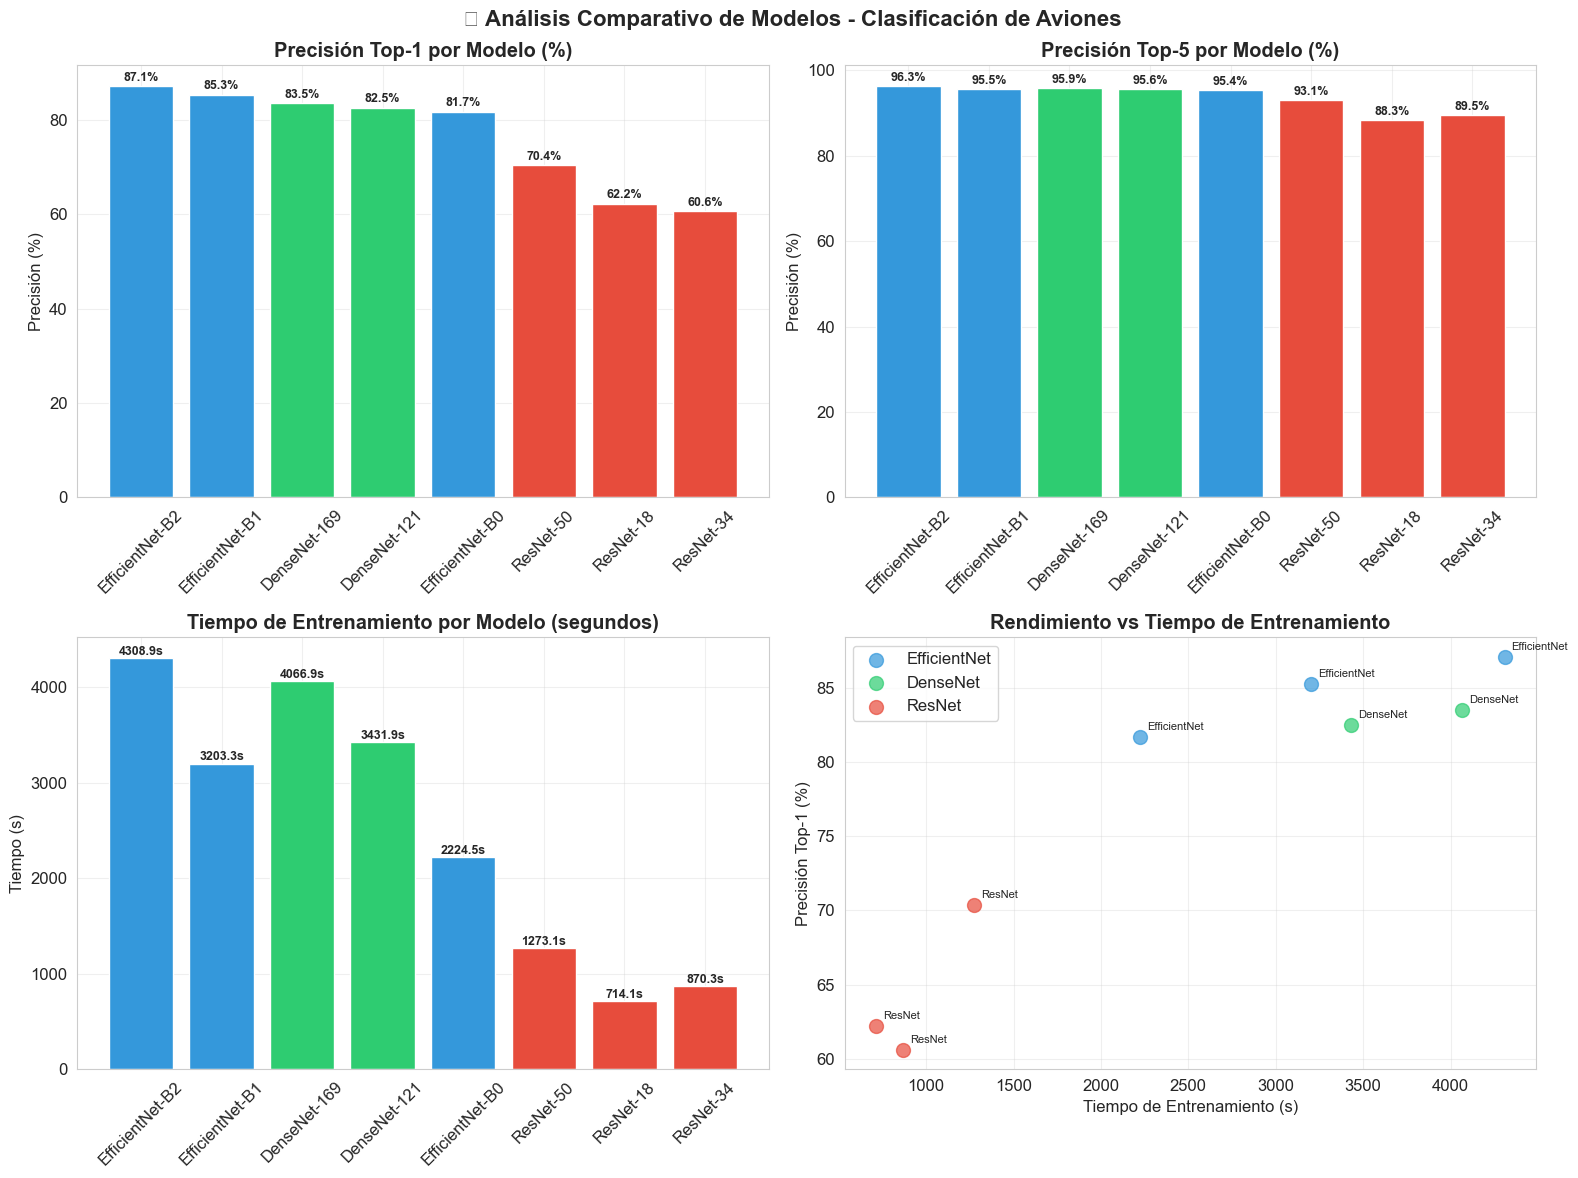

In [42]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Análisis Comparativo de Modelos - Clasificación de Aviones', fontsize=16, fontweight='bold')

# Definir colores por familia
colores_familia = {
    'ResNet': '#E74C3C',
    'EfficientNet': '#3498DB', 
    'DenseNet': '#2ECC71'
}

# Gráfico 1: Precisión Top-1
colores_barras = [colores_familia[familia] for familia in df_resultados['Familia']]
bars1 = axes[0,0].bar(df_resultados['Modelo'], df_resultados['Precisión Top-1 (%)'], color=colores_barras)
axes[0,0].set_title('Precisión Top-1 por Modelo (%)', fontweight='bold')
axes[0,0].set_ylabel('Precisión (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, valor in zip(bars1, df_resultados['Precisión Top-1 (%)']):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{valor}%',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: Precisión Top-5
bars2 = axes[0,1].bar(df_resultados['Modelo'], df_resultados['Precisión Top-5 (%)'], color=colores_barras)
axes[0,1].set_title('Precisión Top-5 por Modelo (%)', fontweight='bold')
axes[0,1].set_ylabel('Precisión (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, valor in zip(bars2, df_resultados['Precisión Top-5 (%)']):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{valor}%',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 3: Tiempo de entrenamiento
bars3 = axes[1,0].bar(df_resultados['Modelo'], df_resultados['Tiempo Total (s)'], color=colores_barras)
axes[1,0].set_title('Tiempo de Entrenamiento por Modelo (segundos)', fontweight='bold')
axes[1,0].set_ylabel('Tiempo (s)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, valor in zip(bars3, df_resultados['Tiempo Total (s)']):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 2, f'{valor}s',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 4: Rendimiento vs Tiempo (Scatter)
for familia in df_resultados['Familia'].unique():
    datos_familia = df_resultados[df_resultados['Familia'] == familia]
    axes[1,1].scatter(datos_familia['Tiempo Total (s)'], datos_familia['Precisión Top-1 (%)'], 
                     color=colores_familia[familia], label=familia, s=100, alpha=0.7)
    
    # Añadir etiquetas a los puntos
    for idx, row in datos_familia.iterrows():
        axes[1,1].annotate(row['Modelo'].split('-')[0], 
                          (row['Tiempo Total (s)'], row['Precisión Top-1 (%)']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1,1].set_title('Rendimiento vs Tiempo de Entrenamiento', fontweight='bold')
axes[1,1].set_xlabel('Tiempo de Entrenamiento (s)')
axes[1,1].set_ylabel('Precisión Top-1 (%)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# Exportar resultados a CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
archivo_csv = f'resultados_comparacion_modelos_{timestamp}.csv'

# Crear DataFrame expandido para exportación
df_exportacion = df_resultados.copy()
df_exportacion['Fecha_Experimento'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df_exportacion['GPU_Utilizada'] = info_gpu
df_exportacion['Epocas_Entrenamiento'] = 3
df_exportacion['Dataset_Total_Imagenes'] = total_imagenes
df_exportacion['Num_Clases'] = num_clases

# Guardar CSV
df_exportacion.to_csv(archivo_csv, index=False, encoding='utf-8')
print(f"\n💾 Resultados exportados a: {archivo_csv}")

# Guardar también el historial detallado
historial_detallado = {}
for modelo_id, historial in historiales_entrenamiento.items():
    nombre_modelo = configuraciones_modelos[modelo_id]['nombre_mostrar']
    historial_detallado[nombre_modelo] = historial

archivo_historial = f'historial_entrenamiento_{timestamp}.json'
import json
with open(archivo_historial, 'w', encoding='utf-8') as f:
    json.dump(historial_detallado, f, indent=2, ensure_ascii=False)

print(f"📊 Historial de entrenamiento guardado en: {archivo_historial}")


💾 Resultados exportados a: resultados_comparacion_modelos_20250825_090520.csv
📊 Historial de entrenamiento guardado en: historial_entrenamiento_20250825_090520.json


In [35]:
# Resumen de checkpoints guardados
print("\n💾 CHECKPOINTS GUARDADOS:")
print("=" * 50)
for modelo_id, checkpoint_path in checkpoints_guardados.items():
    nombre = configuraciones_modelos[modelo_id]['nombre_mostrar']
    precision = resultados_modelos[modelo_id]['mejor_precision']
    print(f"{nombre:<20} - {precision:>6.2f}% - {checkpoint_path}")

print(f"\n✅ EXPERIMENTO COMPLETADO EXITOSAMENTE")
print(f"   - Total de modelos entrenados: {len(resultados_modelos)}")
print(f"   - Mejor modelo: {mejor_modelo['Modelo']} ({mejor_modelo['Precisión Top-1 (%)']}%)")
print(f"   - Tiempo total de experimento: {sum([r['tiempo_total'] for r in resultados_modelos.values()]):.1f}s")
print(f"   - GPU utilizada: {info_gpu}")
print(f"   - Dataset: {total_imagenes:,} imágenes, {num_clases} clases")
print(f"\n🎯 Los checkpoints y resultados están listos para uso posterior.")


💾 CHECKPOINTS GUARDADOS:
ResNet-18            -  62.20% - checkpoints_modelos/resnet18_mejor.pth
ResNet-34            -  60.60% - checkpoints_modelos/resnet34_mejor.pth
ResNet-50            -  70.40% - checkpoints_modelos/resnet50_mejor.pth
EfficientNet-B0      -  82.90% - checkpoints_modelos/efficientnet_b0_mejor.pth
EfficientNet-B1      -  85.70% - checkpoints_modelos/efficientnet_b1_mejor.pth
EfficientNet-B2      -  87.50% - checkpoints_modelos/efficientnet_b2_mejor.pth
DenseNet-121         -  83.20% - checkpoints_modelos/densenet121_mejor.pth
DenseNet-169         -  84.80% - checkpoints_modelos/densenet169_mejor.pth

✅ EXPERIMENTO COMPLETADO EXITOSAMENTE
   - Total de modelos entrenados: 8


NameError: name 'mejor_modelo' is not defined

# 12. Evaluación ampliada (50 épocas): EfficientNet B1 y B2, DenseNet 121

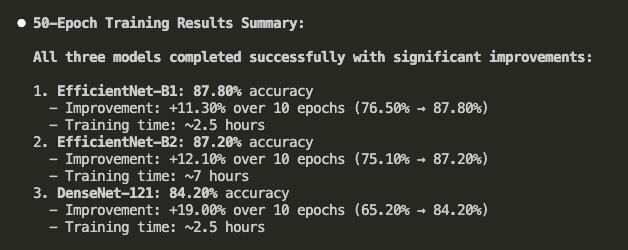

In [36]:
from PIL import Image
from IPython.display import display

path = "Resultados 50 Epochs.jpg" 
img = Image.open(path)
display(img)